<a href="https://colab.research.google.com/github/geoaigroup/models-deployment/blob/main/scripts/process_large_tiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML4CV project work

Summary: Improving and explaining instance segmentation on a litter detection dataset

Members:
- Dell'Olio Domenico
- Delvecchio Giovanni Pio
- Disabato Raffaele

The project was developed in order to improve instance segmentation results on the [TACO Dataset](http://tacodataset.org/).

We decided to implement and test various architectures, among the highest scoring on COCO instance segmentation datasets, in order to compare their performances.
We also tested some explainability methods on these models to try and explain model predictions.

## This notebook contains:
- Wrapper of the MaskDINO model that merges the instance segmentation masks,
casting the instance segmentation task to a semantic segmentation task
- Calls to compute the eigen-cam for semantic segmentation, with the purpose of visualization of the most salient features for the segmentation of images of the validation set

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@5aeb252b194b93dc2879b4ac34bc51a31b5aee13'
%cd /content/
!git clone https://github.com/DomMcOyle/TACO-expl.git
%cd /content/TACO-expl
!git checkout pre_main_merge
!git pull origin pre_main_merge
%cd /content/TACO-expl/MaskDINO
!pip install -r requirements.txt
%cd /content/TACO-expl/MaskDINO/maskdino/modeling/pixel_decoder/ops
!sh make.sh
%cd /content/

In [ ]:
!pip install mmcv==2.1.0 -f https://download.openmmlab.com/mmcv/dist/cu118/torch2.1/index.html
!pip install mmdet

In [1]:
from google.colab import drive
drive.mount("/content/MyDrive/", force_remount = True)

Mounted at /content/MyDrive/


In [2]:
!git clone https://github.com/geoaigroup/GEOAI-ECRS2023.git
!pip install segmentation-models-pytorch
!pip install rasterio
!pip install geopandas
%cd "/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation"
!pwd
!pip install ttach
!pip install grad-cam

Cloning into 'GEOAI-ECRS2023'...
remote: Enumerating objects: 1040, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 1040 (delta 79), reused 24 (delta 24), pack-reused 937
Receiving objects: 100% (1040/1040), 255.54 MiB | 14.08 MiB/s, done.
Resolving deltas: 100% (549/549), done.
Updating files: 100% (177/177), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=5103bd55e5aadfd8c26bdf454496b2f2bc941823a393b2624c8ffa22fbd8e280
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Cre

In [3]:
!mv "/content/TACO-expl/visual_utils.py" "/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation"
%cd "/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation"
!mv utils.py geo_utils.py

/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation


## Note Well
After executing the above cells, the runtime has to be restarted

In [2]:
import torch, detectron2
%cd /content/
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import sys
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

sys.path.append('/content/TACO-expl/MaskDINO/maskdino/')
from config import add_maskdino_config
%cd /content/TACO-expl/MaskDINO/maskdino/
from detectron2.projects.deeplab import add_deeplab_config
from maskdino import MaskDINO
%cd /content/


%cd /content/TACO-expl/
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import os.path
import argparse
import random
import datetime as dt
import copy
import torch.nn as nn
from sklearn.model_selection import train_test_split
from pathlib import Path

import math
import torch.utils.data
from torch.utils.data import DataLoader
from pycocotools import mask as coco_mask

from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog

%cd "/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation"
from visual_utils import *

/content
/content/TACO-expl/MaskDINO/maskdino
/content
/content/TACO-expl
/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation


## Dataset Loading

Here we load the dataset and we inspect the first entry from the validation set

In [3]:
with open("/content/TACO-expl/data/annotations_off_0_train.json", "r") as f:
    dataset = json.loads(f.read())
classes = [elem["name"] for elem in dataset["categories"]]

In [4]:
train_annotation_file = '/content/TACO-expl/data/annotations_off_0_train.json'
val_annotation_file = '/content/TACO-expl/data/annotations_off_0_resval.json'
test_annotation_file = '/content/TACO-expl/data/annotations_off_0_restest.json'

img_dir_train = '/content/MyDrive/MyDrive/res_official/rot_train/'
img_dir_val = '/content/MyDrive/MyDrive/res_official/res_val/'
img_dir_test = '/content/MyDrive/MyDrive/res_official/res_test/'

register_coco_instances("TACO_train", {}, train_annotation_file, img_dir_train)
MetadataCatalog.get("TACO_train").set(thing_classes = classes)
dataset_dicts_train = DatasetCatalog.get("TACO_train")

register_coco_instances("TACO_val", {}, val_annotation_file, img_dir_val)
MetadataCatalog.get("TACO_val").set(thing_classes = classes)
dataset_dicts_val = DatasetCatalog.get("TACO_val")

register_coco_instances("TACO_test", {}, test_annotation_file, img_dir_test)
MetadataCatalog.get("TACO_test").set(thing_classes = classes)
dataset_dicts_test = DatasetCatalog.get("TACO_test")

[06/14 15:47:38 d2.data.datasets.coco]: Loaded 1200 images in COCO format from /content/TACO-expl/data/annotations_off_0_train.json
[06/14 15:47:38 d2.data.datasets.coco]: Loaded 150 images in COCO format from /content/TACO-expl/data/annotations_off_0_resval.json
[06/14 15:47:38 d2.data.datasets.coco]: Loaded 150 images in COCO format from /content/TACO-expl/data/annotations_off_0_restest.json


In [ ]:
first_entry = dataset_dicts_val[0]
first_entry_img = cv2.imread(first_entry["file_name"])

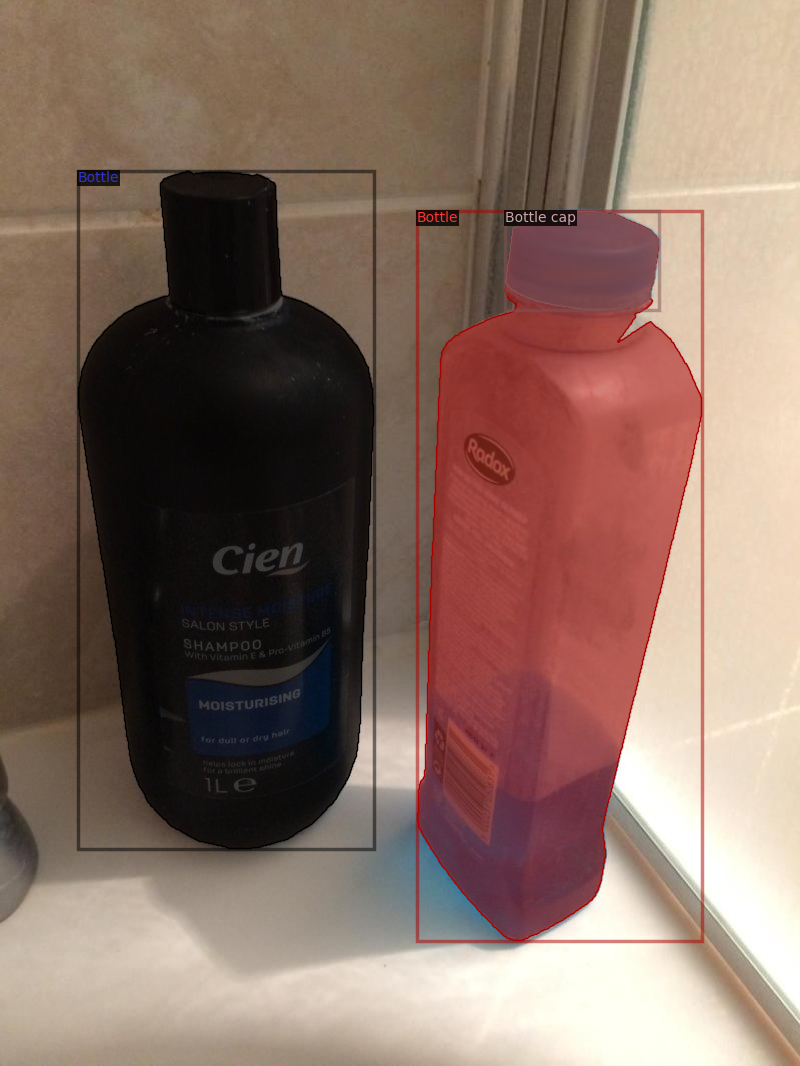

In [ ]:
from detectron2.utils.visualizer import Visualizer
d2_visualizer = Visualizer(first_entry_img, MetadataCatalog.get("TACO_val"))
d2_visualizer = d2_visualizer.draw_dataset_dict(first_entry)
cv2_imshow(d2_visualizer.get_image())

## MaskDINO model loading

Here we load the MaskDINO model with the configurations employed during training.

### Side note:
It is possible to set
- train_cfg_loaded.MODEL.MaskDINO.TEST.INSTANCE_ON = False
- train_cfg_loaded.MODEL.MaskDINO.TEST.SEMANTIC_ON = True

and load the weights of the MaskDINO model optimized for instance segmentation,
to obtain a model that gives as output segmentation masks, however this is just a tweak and results are not guaranteed to be coherent with what has been learned in the other task. This has been proved by analyzing the prediction of the tweaked network and observing that segmentation masks for classes that were missing in the image were non-null.

In [ ]:
train_cfg_loaded = get_cfg()
train_cfg_loaded.set_new_allowed(True)
train_cfg_loaded.merge_from_file("/content/TACO-expl/maskdino_config/taco_train_maskdino.yaml")
print(train_cfg_loaded.MODEL.BACKBONE.FREEZE_AT)
print(train_cfg_loaded.SOLVER.IMS_PER_BATCH)
print(train_cfg_loaded.INPUT.MIN_SIZE_TRAIN)
print(train_cfg_loaded.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN)
print(train_cfg_loaded.TEST.AUG.ENABLED)
print(train_cfg_loaded.INPUT.MASK_FORMAT)
print(train_cfg_loaded.Default_loading)
print(train_cfg_loaded.MODEL.MaskDINO.TEST.INSTANCE_ON)
print(train_cfg_loaded.MODEL.MaskDINO.TEST.SEMANTIC_ON)

0
2
(480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800)
100
False
polygon
False
True
False


In [ ]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

maskdino_model = build_model(train_cfg_loaded)
model_weights_path = "/content/MyDrive/MyDrive/MaskDINO_chkpts/model_final_freeze2.pth"
checkpointer = DetectionCheckpointer(maskdino_model)
checkpointer.load(model_weights_path)

Here we analyze the raw outcome of a prediction to check which tensors have gradients or gradient functions.
Unfortunately, the instance segmentation masks have none of them.

In [ ]:
maskdino_model.eval()
with torch.no_grad():
  height, width = first_entry_img.shape[:2]
  image = torch.as_tensor(first_entry_img.astype("float32").transpose(2, 0, 1))
  image.to("cuda:0")
  inputs = {"image": image, "height": height, "width": width}
  print(inputs["image"].shape)
  predictions = maskdino_model([inputs])[0]

print(predictions)

torch.Size([3, 1066, 800])
{'instances': Instances(num_instances=100, image_height=1066, image_width=800, fields=[pred_masks: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0

In [ ]:
def visualize_mask(single_mask):
  plt.figure(figsize=(10, 10))
  plt.imshow(single_mask)
  plt.colorbar()
  plt.axis('off')
  plt.show()

In [ ]:
from detectron2.modeling import build_model
from detectron2.engine import DefaultPredictor

#load the config file, load weights
train_cfg_loaded = get_cfg()
train_cfg_loaded.set_new_allowed(True)
train_cfg_loaded.merge_from_file("/content/TACO-expl/maskdino_config/taco_train_maskdino.yaml")
train_cfg_loaded.MODEL.WEIGHTS = "/content/MyDrive/MyDrive/MaskDINO_chkpts/model_final_freeze2.pth"
# Create predictor
predictor = DefaultPredictor(train_cfg_loaded)



In [11]:
for i in range(1, 16):
  os.mkdir(f"/content/maskdino out/batch_{i}")

In [78]:
from detectron2.utils.visualizer import Visualizer
from tqdm import tqdm

for i in tqdm(range(len(dataset_dicts_test))):
  first_entry = dataset_dicts_test[i]
  first_entry_img = cv2.imread(first_entry["file_name"])

  d2_visualizer = Visualizer(first_entry_img, MetadataCatalog.get("TACO_test"))
  #predictor.eval()
  with torch.no_grad():
    predictions = predictor(first_entry_img)

  all_instance_scores = predictions["instances"].get_fields()["scores"]
  th_score_idx = np.where(all_instance_scores.cpu() > 0.30)
  filter_instances = predictions['instances'][th_score_idx]
  filter_instances = filter_instances.to('cpu')

  out = d2_visualizer.draw_instance_predictions(filter_instances)
  filename = "/".join(first_entry["file_name"].split("/")[-2:])

  cv2.imwrite("/content/maskdino out/" + filename, out.get_image())


100%|██████████| 150/150 [01:08<00:00,  2.20it/s]


In [79]:
!zip -r maskdino_out030 "/content/maskdino out"

  adding: content/maskdino out/ (stored 0%)
  adding: content/maskdino out/batch_15/ (stored 0%)
  adding: content/maskdino out/batch_15/000053.jpg (deflated 1%)
  adding: content/maskdino out/batch_15/000006.jpg (deflated 1%)
  adding: content/maskdino out/batch_15/000035.jpg (deflated 1%)
  adding: content/maskdino out/batch_15/000000.jpg (deflated 1%)
  adding: content/maskdino out/batch_15/000025.jpg (deflated 1%)
  adding: content/maskdino out/batch_15/000081.jpg (deflated 1%)
  adding: content/maskdino out/batch_15/000078.jpg (deflated 1%)
  adding: content/maskdino out/batch_15/000028.jpg (deflated 1%)
  adding: content/maskdino out/batch_15/000009.jpg (deflated 1%)
  adding: content/maskdino out/batch_10/ (stored 0%)
  adding: content/maskdino out/batch_10/000006.jpg (deflated 1%)
  adding: content/maskdino out/batch_10/000000.jpg (deflated 1%)
  adding: content/maskdino out/batch_10/000014.jpg (deflated 1%)
  adding: content/maskdino out/batch_10/000083.jpg (deflated 1%)
  add

In [17]:
!zip -r ground_truth "/content/ground truth"

  adding: content/ground truth/ (stored 0%)
  adding: content/ground truth/batch_15/ (stored 0%)
  adding: content/ground truth/batch_15/000053.jpg (deflated 1%)
  adding: content/ground truth/batch_15/000006.jpg (deflated 1%)
  adding: content/ground truth/batch_15/000035.jpg (deflated 1%)
  adding: content/ground truth/batch_15/000000.jpg (deflated 1%)
  adding: content/ground truth/batch_15/000025.jpg (deflated 1%)
  adding: content/ground truth/batch_15/000081.jpg (deflated 1%)
  adding: content/ground truth/batch_15/000078.jpg (deflated 0%)
  adding: content/ground truth/batch_15/000028.jpg (deflated 1%)
  adding: content/ground truth/batch_15/000009.jpg (deflated 1%)
  adding: content/ground truth/batch_10/ (stored 0%)
  adding: content/ground truth/batch_10/000006.jpg (deflated 1%)
  adding: content/ground truth/batch_10/000000.jpg (deflated 1%)
  adding: content/ground truth/batch_10/000014.jpg (deflated 1%)
  adding: content/ground truth/batch_10/000083.jpg (deflated 1%)
  add

In [71]:
for i in range(1, 16):
  os.mkdir(f"/content/mfdetr out/batch_{i}")

In [16]:
for i in tqdm(range(len(dataset_dicts_test))):
  first_entry = dataset_dicts_test[i]
  first_entry_img = cv2.imread(first_entry["file_name"])

  d2_visualizer = Visualizer(first_entry_img, MetadataCatalog.get("TACO_test"))
  out = d2_visualizer.draw_dataset_dict(first_entry)

  filename = "/".join(first_entry["file_name"].split("/")[-2:])

  cv2.imwrite("/content/ground truth/" + filename, out.get_image())

100%|██████████| 150/150 [00:25<00:00,  5.87it/s]


## Merging of the masks

In the following cells we aim to modify the raw output of the MaskDINO model to obtain a semantic segmentation mask.

To do so, we need perform a classwise logical or of the instance segmentation
masks.

In [ ]:
print(predictions.keys())
print(predictions["instances"].get_fields().keys())
all_instance_masks = predictions["instances"].get_fields()["pred_masks"]
all_instance_scores = predictions["instances"].get_fields()["scores"]
all_instance_classes = predictions["instances"].get_fields()["pred_classes"]

th_score_idx = np.where(all_instance_scores.cpu() > 0.20)
th_masks = all_instance_masks[th_score_idx, :, :]
th_classes = all_instance_classes[th_score_idx]
n_classes = len(classes)
print(th_score_idx)
print(th_masks.shape)
print(th_classes)
print(n_classes)

dict_keys(['instances'])
dict_keys(['pred_masks', 'pred_boxes', 'scores', 'pred_classes'])
(array([ 0, 10, 21, 30]),)
torch.Size([1, 4, 1066, 800])
tensor([0, 0, 1, 0], device='cuda:0')
10


In [ ]:
def merge_masks(th_masks, th_classes, n_classes):
  masks = th_masks.squeeze(0)
  height, width = masks.shape[1:]
  print(height, width)
  merged = np.zeros((n_classes, height, width))
  for idx, single_mask in enumerate(masks):
    merged[th_classes[idx]] = np.logical_or(merged[th_classes[idx]], single_mask)
  merged = np.expand_dims(merged, 0)
  return merged

merged = merge_masks(th_masks.cpu(), th_classes.cpu(), n_classes)
print(merged.shape)

1066 800
(1, 10, 1066, 800)


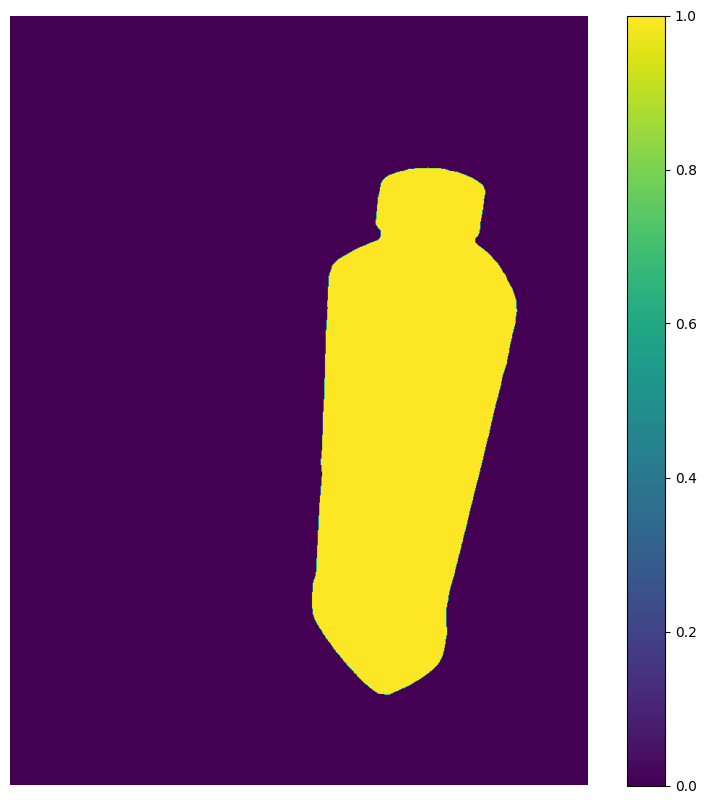

In [ ]:
# Visualization of the first instance semgentation mask
visualize_mask(th_masks[0, 0, :, :].cpu())

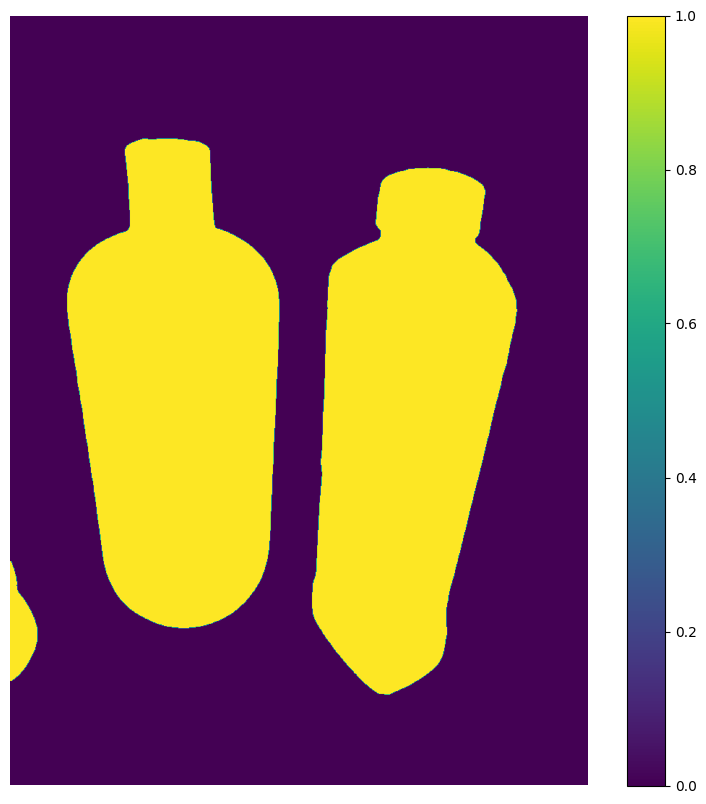

In [ ]:
# visualization of the first semantic segmentation mask
# (merged version of the above object th_masks)
visualize_mask(merged[0, 0, :, :])

## Layer selection

With the aim of applying CAM methods to our semantic segmentation masks,
we need to select certain layers of the backbone (ResNet50), which will be used to produce the maps of the most salient features for the purpose of the segmentation task.

### Side Note:

Some experiments have been carried out with specific layers, but the outcome was negative for various reasons, here we report the most salient ones:
- `backbone.res2.2` is not a valid choice as we get OOM due to the large size of the activation;
- `sem_seg_head.pixel_decoder.input_proj`, `sem_seg_head.predictor.decoder.ref_point_head` and `sem_seg_head.predictor.decoder.layers` cannot be employed due to the different datatype of the weights (`the exact error is ufunc 'isnan' not supported for the input types`)

In [ ]:
#print(maskdino_model.parameters)

target_layers_backbone_5 = [maskdino_model.get_submodule("backbone.res5.2")]
target_layers_backbone_4 = [maskdino_model.get_submodule("backbone.res4.2")]
target_layers_backbone_3 = [maskdino_model.get_submodule("backbone.res3.2")]
target_layers_backbone_5_4 = [maskdino_model.get_submodule("backbone.res4.2"), maskdino_model.get_submodule("backbone.res5.2")]
target_layers_backbone_5_4_3 = [maskdino_model.get_submodule("backbone.res3.2"),
                                maskdino_model.get_submodule("backbone.res4.2"),
                                maskdino_model.get_submodule("backbone.res5.2")]

In [ ]:
from torch.autograd import Variable
import pdb


class DummyDino_seg(nn.Module):
  def __init__(self, dino_model):
    super().__init__()
    self.dino_model = dino_model

  def forward(self, x):
    height = x.shape[-2]
    width = x.shape[-1]
    to_pass = [{"image": x.squeeze(0), "height": height, "width": width}]
    #print(to_pass["image"].shape)
    output = [self.dino_model(to_pass)[0]["sem_seg"]]
    return output

class DummyDino(nn.Module):
  def __init__(self, dino_model, n_classes):
    super().__init__()
    self.dino_model = dino_model
    self.n_classes = n_classes

  def merge_masks(self, th_masks, th_classes):
    masks = th_masks.squeeze(0)
    height, width = masks.shape[1:]
    merged = np.zeros((self.n_classes, height, width))
    for idx, single_mask in enumerate(masks):
      merged[th_classes[idx]] = np.logical_or(merged[th_classes[idx]], single_mask.cpu().numpy())
    merged = torch.tensor(merged).unsqueeze(0).cuda()
    return merged

  def forward(self, x):
    height = x.shape[-2]
    width = x.shape[-1]
    to_pass = [{"image": x.squeeze(0), "height": height, "width": width}]
    output = self.dino_model(to_pass)[0]
    all_instance_masks = output["instances"].get_fields()["pred_masks"]
    all_instance_scores = output["instances"].get_fields()["scores"]
    all_instance_classes = output["instances"].get_fields()["pred_classes"]
    th_score_idx = torch.where(all_instance_scores > 0.20)[0]
    th_masks = all_instance_masks[th_score_idx, :, :]
    th_classes = all_instance_classes[th_score_idx]
    seg_mask = self.merge_masks(th_masks, th_classes)
    return torch.tensor(seg_mask).cuda()

In [ ]:
maskdino_model.eval()
wrapped_dino = DummyDino(maskdino_model, 10)
input_image = totensor(first_entry_img).cuda().requires_grad_()
output = wrapped_dino(input_image)

In [ ]:
target_mask_float = np.float32(output[0, 0, :, :].detach().cpu().numpy())
print(target_mask_float.shape)

(1066, 800)


## EigenCAM plots

A peculiarity that has been found while using these transformer-based models and this type of CAM methods that does not require gradients is that the maps highlight everything but the objects of interest.

This inversion of trend differs from what stated in the [paper](https://https://arxiv.org/pdf/2008.00299), even because the class alone doesn't seem to influence the whole outcome.

running seg-grad-cam...
building activation list...
building gradient list...
Activations list size:  1
Gradients list size:  0
Target layer size:  1
in the loop...


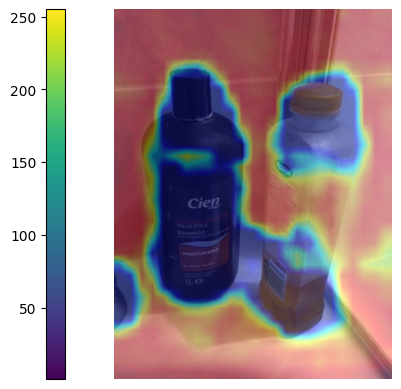

In [ ]:
# if we write any number different from 0 as first argument, the outcome is the same
targets = [SemanticSegmentationTarget(0, target_mask_float)]

print('running seg-grad-cam...')
with GRADCAM_Extensions(extension = "eigen_cam", model=wrapped_dino, target_layers = target_layers_backbone_5, use_cuda=torch.cuda.is_available(), uses_gradients = False) as eigencam:
    grayscale_cam_EX_5 = eigencam(input_tensor=input_image, targets=targets)[0, :]

grayscale_cam_EX_5.shape
[Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(first_entry_img, grayscale_cam_EX_5, 0.006)
plt.imshow(Exmap_sgc)
plt.axis('off')
plt.colorbar(location='left')

running seg-grad-cam...
building activation list...
building gradient list...
Activations list size:  1
Gradients list size:  0
Target layer size:  1
in the loop...


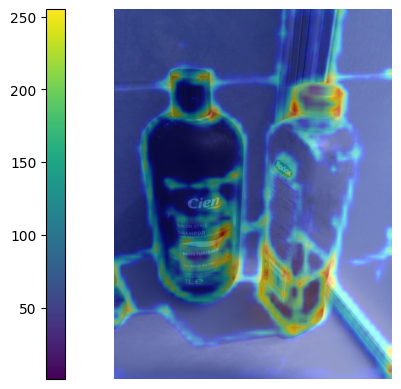

In [ ]:
targets = [SemanticSegmentationTarget(0, target_mask_float)]

print('running seg-grad-cam...')
with GRADCAM_Extensions(extension = "eigen_cam", model=wrapped_dino, target_layers = target_layers_backbone_4, use_cuda=torch.cuda.is_available(), uses_gradients = False) as eigencam:
    grayscale_cam_EX_4 = eigencam(input_tensor=input_image, targets=targets)[0, :]

grayscale_cam_EX_4.shape
[Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(first_entry_img, grayscale_cam_EX_4, 0.006)
plt.imshow(Exmap_sgc)
plt.axis('off')
plt.colorbar(location='left')

running seg-grad-cam...
building activation list...
building gradient list...
Activations list size:  1
Gradients list size:  0
Target layer size:  1
in the loop...


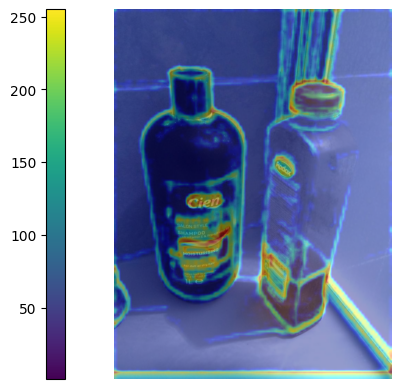

In [ ]:
targets = [SemanticSegmentationTarget(0, target_mask_float)]

print('running seg-grad-cam...')
with GRADCAM_Extensions(extension = "eigen_cam", model=wrapped_dino, target_layers = target_layers_backbone_3, use_cuda=torch.cuda.is_available(), uses_gradients = False) as eigencam:
    grayscale_cam_EX_3 = eigencam(input_tensor=input_image, targets=targets)[0, :]

grayscale_cam_EX_3.shape
[Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(first_entry_img, grayscale_cam_EX_3, 0.006)
plt.imshow(Exmap_sgc)
plt.axis('off')
plt.colorbar(location='left')

running seg-grad-cam...
building activation list...
building gradient list...
Activations list size:  2
Gradients list size:  0
Target layer size:  2
in the loop...
in the loop...


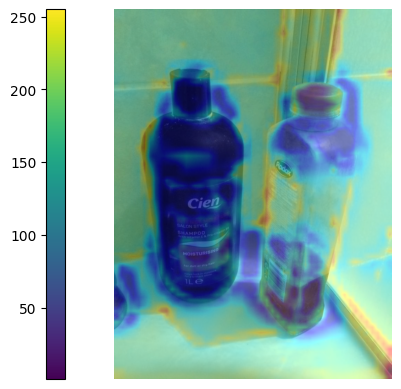

In [ ]:
targets = [SemanticSegmentationTarget(0, target_mask_float)]

print('running seg-grad-cam...')
with GRADCAM_Extensions(extension = "eigen_cam", model=wrapped_dino, target_layers = target_layers_backbone_5_4, use_cuda=torch.cuda.is_available(), uses_gradients = False) as eigencam:
    grayscale_cam_EX_5_4 = eigencam(input_tensor=input_image, targets=targets)[0, :]

grayscale_cam_EX_5_4.shape
[Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(first_entry_img, grayscale_cam_EX_5_4, 0.006)
plt.imshow(Exmap_sgc)
plt.axis('off')
plt.colorbar(location='left')

running seg-grad-cam...
building activation list...
building gradient list...
Activations list size:  3
Gradients list size:  0
Target layer size:  3
in the loop...
in the loop...
in the loop...


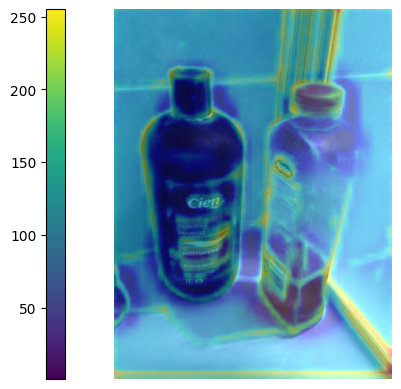

In [ ]:
targets = [SemanticSegmentationTarget(0, target_mask_float)]

print('running seg-grad-cam...')
with GRADCAM_Extensions(extension = "eigen_cam", model=wrapped_dino, target_layers = target_layers_backbone_5_4_3, use_cuda=torch.cuda.is_available(), uses_gradients = False) as eigencam:
    grayscale_cam_EX_5_4_3 = eigencam(input_tensor=input_image, targets=targets)[0, :]

grayscale_cam_EX_5_4_3.shape
[Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(first_entry_img, grayscale_cam_EX_5_4_3, 0.006)
plt.imshow(Exmap_sgc)
plt.axis('off')
plt.colorbar(location='left')

## mfdetr

In [20]:
%cd /content/TACO-expl
from MFDETR import load_mfdetr
from HDDETR.configs.attr_dict import get_DETRargs

mfdetr_path = '/content/MyDrive/MyDrive/checkpointML4CV/MFDETRllmsn2layer4finalcheckpoint_6.pth'
device = "cuda"
num_classes = 10

args = get_DETRargs()
args.aux_loss = False
mfdetr, postprocessor = load_mfdetr(mfdetr_path, args, num_classes, device)
mfdetr = mfdetr.to(device)

/content/TACO-expl
topk for eval: 100


In [32]:
import cv2
import numpy as np
from random import randrange
from HDDETR.util.box_ops import generalized_box_iou

class_names = ["Bottle", "Bottle cap", "Can", "Cigarette", "Cup", "Lid", "Other", "Plastic bag & wrapper", "Pop tab", "Straw"]

def draw_mask(image, mask_generated, label, box):
  label = label - 1

  np_img = np.asarray(image)
  color_cv = list(np.random.random(size=3) * 256)
  color = np.array([color_cv[0], color_cv[1], color_cv[2]])

  masked_image = np.where(mask_generated.astype(int), color, np_img)
  masked_image = masked_image.astype(np.uint8)
  img_with_mask = cv2.addWeighted(np_img, 0.3, masked_image, 0.7, 0)

  start_point = (int(box[0]), int(box[1]))
  end_point = (int(box[2]), int(box[3]))

  img_with_mask = cv2.rectangle(img_with_mask, start_point, end_point, color_cv, 2)
  img_with_mask = cv2.putText(img_with_mask, class_names[label], (int(box[0]), int(box[1]) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1)
  return img_with_mask

def filter_results(results, th_iou=0.001, th_score=0.1):
  res = {"boxes": results[0]["boxes"][0].unsqueeze(0), "labels": results[0]["labels"][0].unsqueeze(0), "masks": results[0]["masks"][0], "scores": results[0]["scores"][0].unsqueeze(0)}

  for (box, label, mask, score) in zip(results[0]["boxes"][1:], results[0]["labels"][1:], results[0]["masks"][1:], results[0]["scores"][1:]):
    scores = generalized_box_iou(box.unsqueeze(0), res["boxes"][res["labels"] == label])

    # if not any([((box == _box).all() and label == _label) for _box, _label in zip(res["boxes"], res["labels"])]):
    if not ((scores > th_iou).any()) and not any([(box == _box).all() for _box in res["boxes"]]) and score > th_score:
      res["boxes"] = torch.vstack((res["boxes"], box))
      res["labels"] = torch.hstack((res["labels"], label))
      res["masks"] = torch.vstack((res["masks"], mask))
      res["scores"] = torch.hstack((res["scores"], score))

  return res

def sort_results_by_score(results):
  _, sorted_indices = torch.sort(results[0]["scores"], descending=True)

  for k, v in results[0].items():
    results[0][k] = torch.stack([v[i] for i in sorted_indices], dim=0)

  return results

In [75]:
import HDDETR.datasets.transforms as T
import HDDETR.util.misc as mutils
from detectron2.structures.instances import Instances

normalize = T.Compose( [T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
transform = T.RandomResize([800], max_size=1333)
postprocessor["segm"].threshold = 0.5
mfdetr.eval()

for i in tqdm(range(len(dataset_dicts_test))):
  first_entry = dataset_dicts_test[i]
  first_entry_img = Image.open(first_entry["file_name"])
  d2_visualizer = Visualizer(first_entry_img, MetadataCatalog.get("TACO_test"))
  img_resized = first_entry_img
  tr_image, _ = normalize(img_resized, target=None)
  tr_image = tr_image.unsqueeze(0)
  batch_input = mutils.collate_fn([tr_image])
  batch_input = batch_input[0].to("cuda")

  output = mfdetr(batch_input)

  orig_target_sizes = torch.tensor([[img_resized.size[1], img_resized.size[0]]]).to("cuda")
  results = postprocessor["bbox"](output, orig_target_sizes)
  results = postprocessor["segm"](results, output, orig_target_sizes, orig_target_sizes)
  sorted_res = sort_results_by_score(results)
  filtered_res = filter_results(sorted_res, 0.001, 0.2)

  filtered_res["pred_masks"] = filtered_res.pop("masks").to("cpu")
  filtered_res["pred_classes"] = filtered_res.pop("labels").to("cpu") - 1
  filtered_res["pred_boxes"] = filtered_res.pop("boxes").to("cpu")
  filtered_res["scores"] = filtered_res["scores"].to("cpu")
  insta = Instances(image_size=(img_resized.size[1], img_resized.size[0]), **filtered_res)
  img_with_mask = d2_visualizer.draw_instance_predictions(insta).get_image()
  pilimg = Image.fromarray(img_with_mask)
  filename = "/".join(first_entry["file_name"].split("/")[-2:])
  pilimg.save("/content/mfdetr out/" + filename)
  #cv2.imwrite("/content/test.ata.png", img_with_mask)

  """
  for (mask, label, box) in zip(filtered_res["masks"], filtered_res["labels"], filtered_res["boxes"]):
    mask = mask.unsqueeze(0)
    mask = mask.cpu().numpy()[0]
    mask = np.stack([mask, mask, mask], axis=-1)
    img_with_mask = draw_mask(img_with_mask, mask, label, box)

  #filename = "/".join(first_entry["file_name"].split("/")[-2:])
  pilimg = Image.fromarray(img_with_mask)
  pilimg.save("/content/test.png")"""





100%|██████████| 150/150 [06:32<00:00,  2.62s/it]


In [76]:
!zip -r mfdetr_out "/content/mfdetr out"

  adding: content/mfdetr out/ (stored 0%)
  adding: content/mfdetr out/batch_15/ (stored 0%)
  adding: content/mfdetr out/batch_15/000053.jpg (deflated 0%)
  adding: content/mfdetr out/batch_15/000006.jpg (deflated 0%)
  adding: content/mfdetr out/batch_15/000035.jpg (deflated 0%)
  adding: content/mfdetr out/batch_15/000000.jpg (deflated 0%)
  adding: content/mfdetr out/batch_15/000025.jpg (deflated 0%)
  adding: content/mfdetr out/batch_15/000081.jpg (deflated 0%)
  adding: content/mfdetr out/batch_15/000078.jpg (deflated 0%)
  adding: content/mfdetr out/batch_15/000028.jpg (deflated 0%)
  adding: content/mfdetr out/batch_15/000009.jpg (deflated 0%)
  adding: content/mfdetr out/batch_10/ (stored 0%)
  adding: content/mfdetr out/batch_10/000006.jpg (deflated 0%)
  adding: content/mfdetr out/batch_10/000000.jpg (deflated 0%)
  adding: content/mfdetr out/batch_10/000014.jpg (deflated 0%)
  adding: content/mfdetr out/batch_10/000083.jpg (deflated 0%)
  adding: content/mfdetr out/batch_10